In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [3]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch
import PIL.ImageOps
import skimage
from sklearn.metrics import confusion_matrix

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title="",
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = ''
        else:
            title = ''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    #im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    im = ax.imshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='',
           xlabel='')
    
    ax.grid(False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i in range(cm.shape[0]):
        #for j in range(cm.shape[1]):
            #ax.text(j, i, format(cm[i, j], fmt),
            #        ha="center", va="center",
            #        color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.savefig("confusion_matrix_raws.png", dpi=300, bbox_inches='tight')
    return ax

In [5]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [6]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

In [7]:
print(len(imagenet_data))

1282


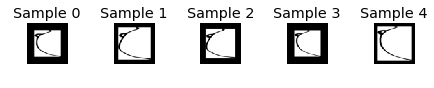

In [8]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [9]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [10]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))



In [11]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [12]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

#### Random split

In [13]:
splits_len

(256, 128, 898)

In [14]:
splits_len = (256, 128, 898)

In [15]:
np.sum(splits_len)

1282

In [16]:
#All
splits = utils.random_split(imagenet_data, splits_len)
print(splits_len)

(256, 128, 898)


In [17]:
import pickle
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)
print(len(splits[0].indices))

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)
print(len(splits[2].indices))

256
898


In [18]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)

In [19]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [20]:
C =_C(input_h_w=64)
C = C.to(available_device)

In [21]:
checkpoint = torch.load("models/checkpoints_data/cnn_vessels_model_500.pth")
C.load_state_dict(checkpoint)

In [22]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

def iterations_test_partial(C, test_loader):
    y_real = list()
    y_pred = list()
    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C.forward_partial(val_input)
        y_pred_batch = score.detach().cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

def iterations_test_pixel(C, test_loader):
    y_real = list()
    y_pred = list()
    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = val_input
        y_pred_batch = score.detach().cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [23]:
y_real_test, X_test = iterations_test_pixel(C, test_loader)
y_real_train, X_train = iterations_test_pixel(C, train_loader)

In [24]:
len(X_test), len(X_train)

(256, 898)

In [25]:
y_real_test, X_test = np.array(y_real_test), np.array(X_test).reshape(-1, 64*64)
y_real_train, X_train = np.array(y_real_train), np.array(X_train).reshape(-1, 64*64)

In [26]:
import pandas as pd
from time import time
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Train

In [27]:
N_CLUSTERS = 4

In [28]:
plt.rcParams['figure.figsize'] = [6.0 * 1.5 , 4.0 * 1.5]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_train)
km = KMeans(n_clusters=N_CLUSTERS, random_state=0)
lbls_train = km.fit_predict(X_tsne)

In [29]:
files_train = np.array(imagenet_data.imgs)[train_loader.dataset.indices][:, 0]

In [30]:
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(lbls_train, 1)), axis=1))

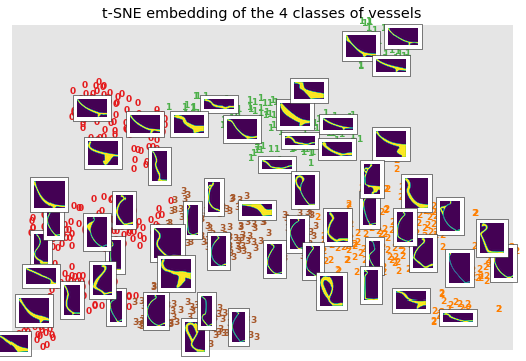

In [31]:
utils.plot_embedding(X_tsne, merged_train, "t-SNE embedding of the {} classes of vessels".format(N_CLUSTERS), N_CLUSTERS)
plt.grid()
plt.show()

# Test

In [32]:
plt.rcParams['figure.figsize'] = [6.0 * 1.5 , 4.0 * 1.5]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_test)
km = KMeans(n_clusters=N_CLUSTERS, random_state=0)
lbls_test = km.fit_predict(X_tsne)

In [33]:
files_test = np.array(imagenet_data.imgs)[test_loader.dataset.indices][:, 0]

In [34]:
merged_test = pd.DataFrame(np.concatenate(( np.expand_dims(files_test, 1), np.expand_dims(lbls_test, 1)), axis=1))

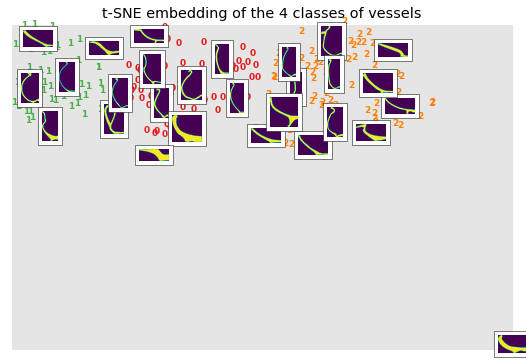

In [35]:
utils.plot_embedding(X_tsne, merged_test, "t-SNE embedding of the {} classes of vessels".format(N_CLUSTERS), N_CLUSTERS)
plt.grid()
plt.show()

<Figure size 1296x864 with 0 Axes>

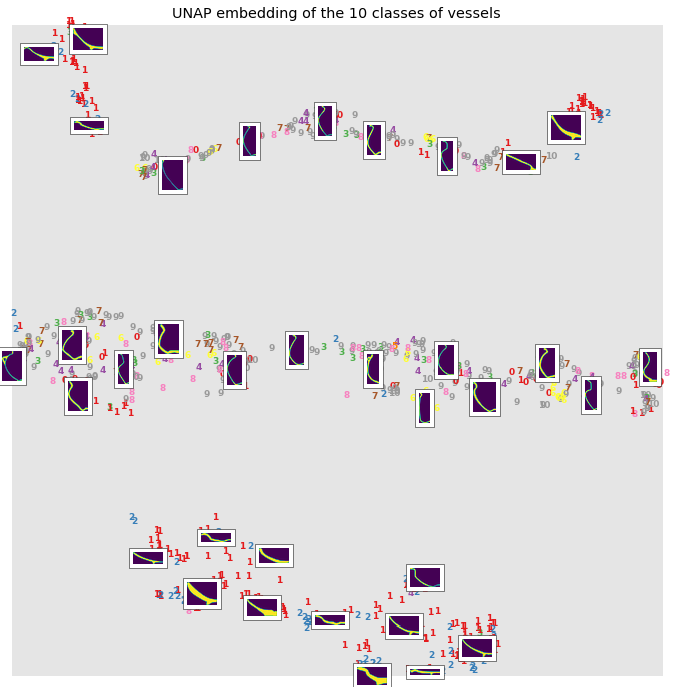

In [36]:
import umap
plt.rcParams['figure.figsize'] = [9.0*2, 6.0*2]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))
fit = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean'
    )
u = fit.fit_transform(X_train);
fig = plt.figure()
#ax = fig.add_subplot(111)
utils.plot_embedding(u[:,[0,1]], merged_train, "UNAP embedding of the {} classes of vessels".format(10), 10)
#ax.scatter(u[:,0], u[:,1], c=c)
plt.gca().set_aspect('equal')
plt.savefig("unap_resnet.png", dpi=300, bbox_inches='tight')
plt.show()

# SVM

In [37]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.86      0.96      0.91        77
           2       0.95      0.70      0.81        30
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00         2
           6       1.00      0.25      0.40         8
           7       0.00      0.00      0.00        10
           8       0.40      0.22      0.29         9
           9       0.53      0.99      0.69        76
          10       0.00      0.00      0.00         5

   micro avg       0.68      0.68      0.68       256
   macro avg       0.34      0.28      0.28       256
weighted avg       0.57      0.68      0.60       256

Normalized confusion matrix


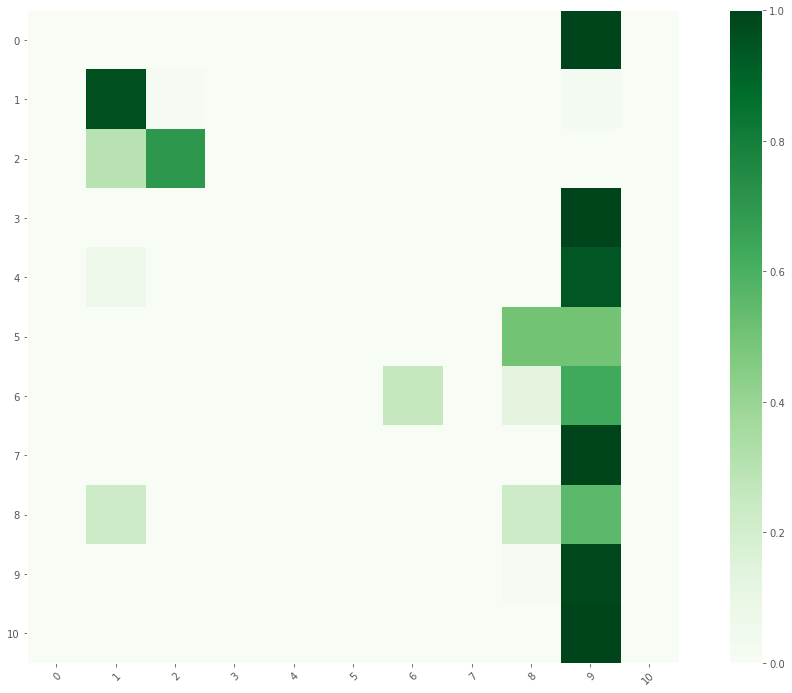

In [38]:
print(metrics.classification_report(np.array(y_real_test), np.array(y_pred_test)))
plot_confusion_matrix(y_real_test, y_pred_test, classes=list(range(10)), normalize=True)

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate


In [40]:
X_train, y_real_train = np.array(X_train), np.array(y_real_train)
X_test, y_real_test = np.array(X_test), np.array(y_real_test)

In [41]:
X_train.shape, y_real_train.shape

((898, 4096), (898,))

In [42]:
X_test.shape, y_real_test.shape

((256, 4096), (256,))

In [43]:
X_train = np.concatenate((X_train, X_test))

In [44]:
y_real_train = np.concatenate((y_real_train, y_real_test))

In [45]:
from sklearn.metrics import precision_score 
import sklearn
precision = lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro')

clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=sklearn.metrics.make_scorer(precision), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train Accuracy: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Accuracy: 0.57 (+/- 0.12)
Test Accuracy: 0.34 (+/- 0.08)


In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=sklearn.metrics.make_scorer(precision), cv=cv,return_estimator=True) 
print("Train Accuracy: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Accuracy: 0.21 (+/- 0.00)
Test Accuracy: 0.19 (+/- 0.01)
